In [1]:
import os
os.getcwd()

'C:\\Users\\bryan\\Documents\\Segmentation\\mmsegmentation'

In [3]:
import numpy as np
import time
import shutil

import torch

from PIL import Image
import cv2

import mmcv
import mmengine
from mmseg.apis import init_model, inference_model
from mmseg.utils import register_all_modules
register_all_modules()

from mmseg.datasets import CityscapesDataset

In [4]:
# Model config File
config_file = 'configs/segformer/segformer_mit-b5_8xb1-160k_cityscapes-1024x1024.py'

# Model checkpoint weight file
checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

In [5]:
model = init_model(config_file, checkpoint_file, device='cuda:0')

C:\Users\bryan\Documents\Segmentation\mmsegmentation\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
C:\Users\bryan\Documents\Segmentation\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth


In [6]:
input_video = 'data/street_20220330_174028.mp4'

In [7]:
temp_out_dir = time.strftime('%Y%m%d%H%M%S')
os.mkdir(temp_out_dir)
print('Create Temp folder {} Store predtict result frame by frame'.format(temp_out_dir))

Create Temp folder 20240318203406 Store predtict result frame by frame


In [8]:
# get Cityscapes street dataset, classes and palette
from mmseg.datasets import cityscapes
classes = cityscapes.CityscapesDataset.METAINFO['classes']
palette = cityscapes.CityscapesDataset.METAINFO['palette']

In [9]:
def predict_single_frame(img, opacity=0.2):
    
    result = inference_model(model, img)
    
    # Color segmented image
    seg_map = np.array(result.pred_sem_seg.data[0].detach().cpu().numpy()).astype('uint8')
    seg_img = Image.fromarray(seg_map).convert('P')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    
    show_img = (np.array(seg_img.convert('RGB')))*(1-opacity) + img*opacity
    
    return show_img

In [10]:
# Load the video need to be precessed
imgs = mmcv.VideoReader(input_video)
prog_bar = mmengine.ProgressBar(len(imgs))

# Process video frame by frame
for frame_id, img in enumerate(imgs):
    
    ## Process single frame image
    show_img = predict_single_frame(img, opacity=0.15)
    temp_path = f'{temp_out_dir}/{frame_id:06d}.jpg' # keep predicted result(image) to temp folder
    cv2.imwrite(temp_path, show_img)

    prog_bar.update() # update progress

# Combine frame images back to video
mmcv.frames2video(temp_out_dir, 'outputs/B3_video.mp4', fps=imgs.fps, fourcc='mp4v')

shutil.rmtree(temp_out_dir) # delete temperary folder
print('Delete Temperary Folder', temp_out_dir)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 138/138, 51.3 task/s, elapsed: 3s, ETA:     0s[                                                  ] 0/138, elapsed: 0s, ETA:
Delete Temperary Folder 20240318203406


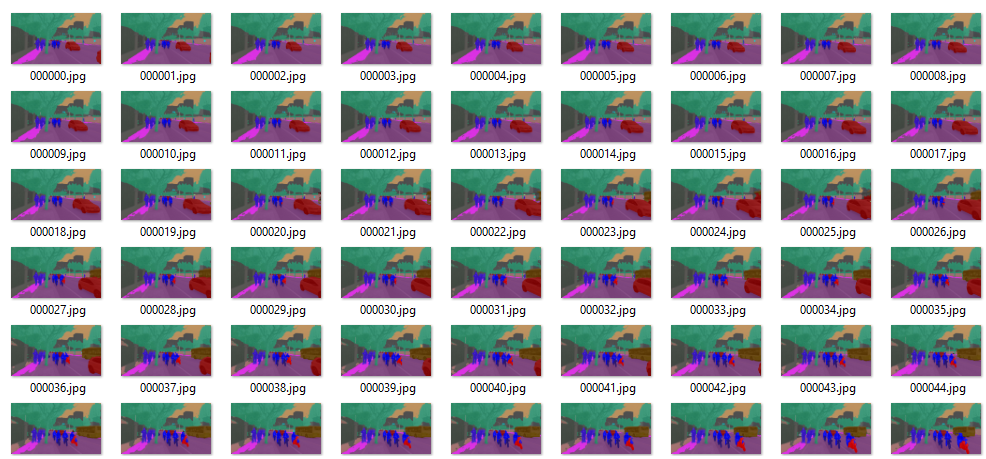